# Backpropagation Through Time (BPTT) と PyTorchによるRNNの実装

このノートブックでは、リカレントニューラルネットワーク（RNN）の学習アルゴリズムであるBackpropagation Through Time (BPTT) の概念を学び、NumPyを使ってその主要な計算ステップを実装します。
その後、PyTorchの組み込みRNNモジュールを使って、より簡単にRNNを構築し学習させる方法を示します。

**参考論文:**
*   Werbos, P. J. (1990). Backpropagation through time: what it does and how to do it. *Proceedings of the IEEE*, 78(10), 1550-1560.
*   Elman, J. L. (1990). Finding structure in time. *Cognitive science*, 14(2), 179-211. (SRNの参照として)

**このノートブックで学ぶこと:**
1.  BPTTの基本的な考え方と、時間展開されたネットワークにおける誤差逆伝播。
2.  NumPyによる単純なRNN（SRN/Elman Network風）の順伝播とBPTTの主要な計算ステップの実装。
3.  PyTorchの `nn.RNN` モジュールを使ったRNNモデルの実装。
4.  PyTorchの自動微分がBPTTをどのように処理するかの確認。
5.  簡単なシーケンス予測タスクでの学習と評価。

**前提知識:**
*   SRN/Elman Networkの基本的な構造と順伝播の理解（前のノートブック）。
*   フィードフォワードニューラルネットワークの逆伝播（バックプロパゲーション）の理解。
*   PyTorchの基本的な使い方（テンソル、`nn.Module`、Optimizerなど）。

## 1. 必要なライブラリのインポート

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

print(f"NumPy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NumPy Version: 1.26.4
PyTorch Version: 2.7.0+cpu
Using device: cpu


## 2. Backpropagation Through Time (BPTT) の概念

リカレントニューラルネットワーク (RNN) は、内部に状態を持ち、過去の情報を現在の処理に利用できるネットワークです。この再帰的な構造のため、通常のバックプロパゲーションを直接適用することはできません。BPTTは、RNNを時間軸に沿って展開し、各タイムステップを一つの層と見なすことで、通常のバックプロパゲーションを適用可能にする手法です。

### 2.1 RNNの時間展開

例えば、時刻 $t$ における隠れ状態 $h_t$ と出力 $\hat{y}_t$ が以下のように計算される単純なRNN（SRN/Elman Network）を考えます。

$h_t = \sigma_h (W_{xh} x_t + W_{hh} h_{t-1} + b_h)$
$\hat{y}_t = \sigma_y (W_{hy} h_t + b_y)$

このRNNを時間ステップ $T$ まで展開すると、以下の図のように、各タイムステップが層として繋がり、重み $W_{xh}, W_{hh}, W_{hy}$ が全てのタイムステップで共有される、非常に深いフィードフォワードネットワークと見なすことができます。

```
Input:    x_1        x_2        x_3        ...   x_T
           |          |          |                |
h_0 ---> RNN_Cell_1 -> RNN_Cell_2 -> RNN_Cell_3 -> ... -> RNN_Cell_T ---> h_T
           |          |          |                |
Output:   y_hat_1    y_hat_2    y_hat_3    ...   y_hat_T
```

各 `RNN_Cell_t` は同じパラメータ $(W_{xh}, W_{hh}, W_{hy}, b_h, b_y)$ を使用します。

### 2.2 BPTTの計算ステップ

1.  **順伝播:** 入力シーケンス $x_1, \dots, x_T$ をRNNに入力し、各時刻 $t$ での隠れ状態 $h_t$ と出力 $\hat{y}_t$ を計算し、保存します。
2.  **損失計算:** 各時刻の出力 $\hat{y}_t$ と真のターゲット $y_t$ から、シーケンス全体の損失 $L = \sum_{t=1}^{T} L_t$ を計算します。$L_t$ は時刻 $t$ での損失です。
3.  **逆伝播:**
    *   まず、最終時刻 $T$ から逆向きに勾配を計算し始めます。
        $\frac{\partial L}{\partial \hat{y}_T} = \frac{\partial L_T}{\partial \hat{y}_T}$
        この勾配を使って、$\frac{\partial L}{\partial W_{hy}}, \frac{\partial L}{\partial b_y}, \frac{\partial L}{\partial h_T}$ を計算します。
    *   次に、時刻 $t$ ($T-1$ から $1$ へ) における勾配を計算します。
        隠れ状態 $h_t$ に対する勾配 $\delta_{h,t} = \frac{\partial L}{\partial h_t}$ は、2つの経路からの寄与を受けます。
        1.  時刻 $t$ の出力 $\hat{y}_t$ からの寄与: $\frac{\partial L_t}{\partial h_t} = \frac{\partial L_t}{\partial \hat{y}_t} \frac{\partial \hat{y}_t}{\partial h_t}$
        2.  時刻 $t+1$ の隠れ状態 $h_{t+1}$ からの寄与（リカレント接続を経由）: $\frac{\partial L}{\partial h_{t+1}} \frac{\partial h_{t+1}}{\partial h_t}$
        よって、$\delta_{h,t} = \left( \frac{\partial \hat{y}_t}{\partial h_t} \right)^T \frac{\partial L_t}{\partial \hat{y}_t} + \left( \frac{\partial h_{t+1}}{\partial h_t} \right)^T \delta_{h,t+1}$
        ここで、$\frac{\partial h_{t+1}}{\partial h_t} = \sigma_h'(net_{h,t+1}) W_{hh}$ です。
    *   計算された $\delta_{h,t}$ を使って、その時刻 $t$ における $W_{xh}, W_{hh}, b_h$ に対する勾配の寄与分を計算します。
4.  **勾配の合計:** 各パラメータ ($W_{xh}, W_{hh}, W_{hy}, b_h, b_y$) に対する勾配は、全てのタイムステップからの寄与分を合計（または平均）したものになります。
    $\frac{\partial L}{\partial W} = \sum_{t=1}^{T} \frac{\partial L_t}{\partial W}$ （$W$は共有パラメータ）

**Truncated BPTT:**
長いシーケンスの場合、完全なBPTTは計算コストが高く、勾配消失/爆発の問題も顕著になります。そのため、実際には一定のステップ数（例: $k$ステップ）だけ時間を遡って勾配を計算するTruncated BPTTがよく用いられます。

### 3.1 SRNの構成要素 (再掲と調整)

In [70]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative_from_activation(activation_value): # シグモイドの出力値から微分を計算
    return activation_value * (1 - activation_value)

def initialize_srn_parameters(input_size, hidden_size, output_size, random_seed=42):
    if random_seed is not None: np.random.seed(random_seed)
    W_xh = np.random.randn(input_size, hidden_size) * 0.01
    W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
    b_h = np.zeros((1, hidden_size))
    W_hy = np.random.randn(hidden_size, output_size) * 0.01
    b_y = np.zeros((1, output_size))
    return {"W_xh": W_xh, "W_hh": W_hh, "b_h": b_h, "W_hy": W_hy, "b_y": b_y}

# 順伝播 (1ステップとシーケンス全体 - 前のノートブックから流用)
def srn_forward_step(xt, h_prev, parameters):
    W_xh, W_hh, b_h = parameters["W_xh"], parameters["W_hh"], parameters["b_h"]
    W_hy, b_y = parameters["W_hy"], parameters["b_y"]
    if xt.ndim == 1: xt = xt.reshape(1, -1)
    if h_prev.ndim == 1: h_prev = h_prev.reshape(1, -1)
    net_h_t = np.dot(xt, W_xh) + np.dot(h_prev, W_hh) + b_h
    h_t = sigmoid(net_h_t)
    net_y_t = np.dot(h_t, W_hy) + b_y
    y_hat_t = sigmoid(net_y_t) # 出力もSigmoidと仮定 (タスクによる)
    cache_t = {"xt": xt, "h_prev": h_prev, "h_t": h_t, "net_h_t": net_h_t, 
               "y_hat_t": y_hat_t, "net_y_t": net_y_t}
    return y_hat_t, h_t, cache_t

def srn_forward_sequence(X_sequence, h0, parameters):
    T, _ = X_sequence.shape
    Y_hat_sequence = np.zeros((T, parameters["b_y"].shape[1]))
    H_sequence = np.zeros((T + 1, parameters["W_hh"].shape[0]))
    Caches_sequence = [None] * T # 各ステップのキャッシュを保存
    
    h_prev = h0.copy() # h0をコピーして使う
    H_sequence[0,:] = h_prev.flatten()
    
    for t in range(T):
        xt = X_sequence[t, :]
        y_hat_t, h_t, cache_t = srn_forward_step(xt, h_prev, parameters)
        Y_hat_sequence[t,:] = y_hat_t.flatten()
        H_sequence[t+1,:] = h_t.flatten()
        Caches_sequence[t] = cache_t
        h_prev = h_t
        
    return Y_hat_sequence, H_sequence, Caches_sequence

# 損失関数 (MSE)
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

### 3.2 BPTTのNumPy実装

シーケンス全体の損失 $L$ を考えます。簡単のため、各タイムステップでの損失を $L_t = \frac{1}{2} (\hat{y}_t - y_t)^2$ とし、$\frac{\partial L_t}{\partial \hat{y}_t} = \hat{y}_t - y_t$ とします。（ここで $y_t$ は真のターゲット、$\hat{y}_t$ は予測値）。
シーケンス全体の損失は $L = \sum_{t=1}^{T} L_t$ です。
BPTTでは、この全体の損失 $L$ に対する各パラメータの勾配 $\frac{\partial L}{\partial W}$ を計算します。これは、各タイムステップ $t$ における局所的な損失 $L_t$ に対する勾配 $\frac{\partial L_t}{\partial W}$ を計算し、それらを時間軸に沿って合計（または平均）することで得られます。

**逆伝播の主要なステップ (時刻 $t$ から $t-1$ へ):**

1.  **出力層の勾配:**
    *   時刻 $t$ での出力 $\hat{y}_t$ に対する損失 $L_t$ の勾配:
        $\frac{\partial L_t}{\partial \hat{y}_t} = \hat{y}_t - y_t$ (これを `dY_hat_t` とする)
    *   出力層の活性化前 $net_{y,t}$ に対する勾配 $\frac{\partial L_t}{\partial net_{y,t}}$ (これを `d_net_y_t` とする):
        `d_net_y_t` $= \frac{\partial L_t}{\partial \hat{y}_t} \cdot \frac{\partial \hat{y}_t}{\partial net_{y,t}} = (\hat{y}_t - y_t) \odot \sigma_y'(net_{y,t})$
        ここで $\sigma_y'(net_{y,t})$ は出力層活性化関数の微分（Sigmoidなら $\hat{y}_t(1-\hat{y}_t)$）。
    *   $W_{hy}$ と $b_y$ に対する勾配の寄与分 (時刻 $t$ のみ考慮):  
        $\frac{\partial L_t}{\partial W_{hy}} = h_t^T \cdot dnet_{y,t}$  
        $\frac{\partial L_t}{\partial b_y} = dnet_{y,t}$ (実際には合計または平均)

2.  **隠れ層 $h_t$ への勾配伝播:**
    *   時刻 $t$ の隠れ状態 $h_t$ に対する全体の損失 $L$ の勾配 $\frac{\partial L}{\partial h_t}$ (これを `dh_t_total` とする) は、
        1.  時刻 $t$ の出力層からの寄与: $\left(\frac{\partial net_{y,t}}{\partial h_t}\right)^T \frac{\partial L_t}{\partial net_{y,t}} = W_{hy}^T \cdot dnet_{y,t}$
        2.  時刻 $t+1$ の隠れ層(の活性化前入力 $net_{h,t+1}$)からの寄与（リカレント接続を通じて）: $\left(\frac{\partial net_{h,t+1}}{\partial h_t}\right)^T \frac{\partial L}{\partial net_{h,t+1}}$
           ここで、$\frac{\partial L}{\partial net_{h,t+1}}$ は未来（時刻 $t+1$）から伝播してきた `d_net_h_next` に相当します。
           $\frac{\partial net_{h,t+1}}{\partial h_t} = W_{hh}$
           よって、この項は $W_{hh}^T \cdot dnet_{h,t+1}$ となります。
        `dh_t_total` = (`dL_t/d_net_y_t` @ `W_hy`.T) + (`d_net_h_next` @ `W_hh`.T) $\times$ `sigmoid_derivative(h_t)` (これは少し不正確、正しくは下記)
        
        より正確には、$\frac{\partial L}{\partial h_t}$ を計算し、次に $\frac{\partial L}{\partial net_{h,t}}$ を計算します。
        $\frac{\partial L}{\partial h_t} = W_{hy}^T \cdot dnet_{y,t} + dh_{t+1}$
        (ここで `dh_next` は、時刻 $t+1$ から $h_t$ へ逆伝播してきた勾配 $\frac{\partial L}{\partial h_t}$ (未来からの寄与)。初期値（最終ステップの次）はゼロ。)
        
    *   隠れ層の活性化前 $net_{h,t}$ に対する勾配 $\frac{\partial L}{\partial net_{h,t}}$ (これを `d_net_h_t` とする):
        `d_net_h_t` $= \frac{\partial L}{\partial h_t} \odot \sigma_h'(net_{h,t})$
        （Sigmoidなら $h_t(1-h_t)$）

3.  **隠れ層のパラメータ $W_{xh}, W_{hh}, b_h$ への勾配:**
    *   $\frac{\partial L}{\partial W_{xh}}$ (の時刻 $t$ での寄与分) $= dnet_{h,t}$
    *   $\frac{\partial L}{\partial W_{hh}}$ (の時刻 $t$ での寄与分) $= h_{t-1}^T \cdot dnet_{h,t}$
    *   $\frac{\partial L}{\partial b_h}$ (の時刻 $t$ での寄与分) $= dnet_{h,t}$

4.  **前時刻の隠れ状態 $h_{t-1}$ への勾配伝播:**
    *   `dh_next` (for step $t-1$) $= \left(\frac{\partial net_{h,t}}{\partial h_{t-1}}\right)^T \frac{\partial L}{\partial net_{h,t}} = W_{hh}^T \cdot dnet_{h,t}$
        この `dh_next` が、次のループ（時刻 $t-1$）での $\frac{\partial L}{\partial h_{t-1}}$ の計算に使われます。

最終的な各パラメータの勾配は、全タイムステップでの寄与を合計し、シーケンス長（またはバッチサイズ）で割って平均化します。

In [71]:
def srn_bptt(Y_true_sequence, Y_hat_sequence, H_sequence, Caches_sequence, parameters):
    '''
    SRNのBPTT (Backpropagation Through Time) をNumPyで実装
    Parameters:
        Y_true_sequence: (T, output_size) - 正解ラベルのシーケンス
        Y_hat_sequence: (T, output_size) - モデルの予測出力シーケンス
        H_sequence: (T+1, hidden_size) - 隠れ層の状態シーケンス
        Caches_sequence: list of dicts - 各タイムステップのキャッシュ
        parameters: dict - モデルパラメータ (W_xh, W_hh, b_h, W_hy, b_y)
    Returns:
        grads: dict - 各パラメータの勾配 (dW_xh, dW_hh, db_h, dW_hy, db_y)
    '''
    T, output_size = Y_true_sequence.shape
    _, hidden_size = H_sequence.shape # H_sequence は (T+1, hidden_size)

    # 勾配を格納する辞書を初期化
    grads = {
        "dW_xh": np.zeros_like(parameters["W_xh"]),
        "dW_hh": np.zeros_like(parameters["W_hh"]),
        "db_h":  np.zeros_like(parameters["b_h"]),
        "dW_hy": np.zeros_like(parameters["W_hy"]),
        "db_y":  np.zeros_like(parameters["b_y"])
    }
    
    # 出力層の活性化関数がSigmoid、損失関数がMSE L=0.5*(y_hat-y_true)^2 の場合
    # dL/dy_hat_t = y_hat_t - y_true_t
    dY_hat = Y_hat_sequence - Y_true_sequence  # (T, output_size)
    
    # dh_next は、次のタイムステップ (未来) から現在の隠れ層h_tに伝播してくる勾配 dL/dh_t
    # 最終タイムステップTでは、未来からの勾配はないのでゼロで初期化
    dh_next = np.zeros((1, hidden_size)) 
    
    # 時間を逆向きにループ (t = T-1, T-2, ..., 0)
    for t in reversed(range(T)):
        # 現在のタイムステップtのキャッシュとパラメータを取得
        cache_t = Caches_sequence[t]
        xt = cache_t["xt"]            # (1, input_size)
        h_prev = cache_t["h_prev"]    # (1, hidden_size) = H_sequence[t]
        h_t = cache_t["h_t"]          # (1, hidden_size) = H_sequence[t+1]
        y_hat_t = cache_t["y_hat_t"]  # (1, output_size)
        
        W_hy = parameters["W_hy"]     # (hidden_size, output_size)
        W_hh = parameters["W_hh"]     # (hidden_size, hidden_size)

        # 1. 出力層の勾配
        # dL_t/d_net_y_t = (dL_t/dy_hat_t) * (dy_hat_t/d_net_y_t)
        dy_hat_t_current = dY_hat[t].reshape(1, -1) # (1, output_size)
        # dy_hat_t/d_net_y_t = sigmoid_derivative_from_activation(y_hat_t)
        d_net_y_t = dy_hat_t_current * sigmoid_derivative_from_activation(y_hat_t) # (1, output_size)
        
        # dL/dW_hy と dL/db_y の寄与分を蓄積
        grads["dW_hy"] += np.dot(h_t.T, d_net_y_t) # (hidden,1) @ (1,out) -> (hidden,out)
        grads["db_y"] += np.sum(d_net_y_t, axis=0, keepdims=True) # (1,out)

        # 2. 隠れ層 h_t への勾配伝播
        # dL/dh_t = (dL_t/d_net_y_t @ W_hy.T) + (dL/dh_{t+1} からの寄与 dh_next)
        dh_t_from_output = np.dot(d_net_y_t, W_hy.T) # (1,out) @ (out,hidden) -> (1,hidden)
        dh_t_total = dh_t_from_output + dh_next      # (1,hidden)
        
        # 3. 隠れ層の活性化前 net_h_t への勾配
        # dL/d_net_h_t = (dL/dh_t) * (dh_t/d_net_h_t)
        # dh_t/d_net_h_t = sigmoid_derivative_from_activation(h_t)
        d_net_h_t = dh_t_total * sigmoid_derivative_from_activation(h_t) # (1,hidden)
        
        # 4. 隠れ層のパラメータ W_xh, W_hh, b_h への勾配の寄与分を蓄積
        grads["dW_xh"] += np.dot(xt.T, d_net_h_t)     # (in,1) @ (1,hidden) -> (in,hidden)
        grads["dW_hh"] += np.dot(h_prev.T, d_net_h_t) # (hidden,1) @ (1,hidden) -> (hidden,hidden)
        grads["db_h"] += np.sum(d_net_h_t, axis=0, keepdims=True) # (1,hidden)
        
        # 5. 前時刻の隠れ状態 h_{t-1} への勾配伝播 (次のループの dh_next になる)
        # dL/dh_{t-1} の一部 = (dL/d_net_h_t) @ W_hh.T
        dh_next = np.dot(d_net_h_t, W_hh.T) # (1,hidden) @ (hidden,hidden) -> (1,hidden)
        
    # シーケンス長で勾配を平均化
    for key in grads:
        grads[key] /= T
        
    return grads

# パラメータ更新 (再掲)
def update_srn_parameters(parameters, grads, learning_rate):
    """ SGDでSRNのパラメータを更新 """
    # parameters のキー ("W_xh", "b_h" など) を元に、
    # grads のキー ("dW_xh", "db_h" など) を生成してアクセスする
    
    parameters["W_xh"] -= learning_rate * grads["dW_xh"]
    parameters["W_hh"] -= learning_rate * grads["dW_hh"]
    parameters["b_h"]  -= learning_rate * grads["db_h"]
    parameters["W_hy"] -= learning_rate * grads["dW_hy"]
    parameters["b_y"]  -= learning_rate * grads["db_y"]
    
    return parameters

### 3.3 Temporal XOR問題でのBPTT学習 (NumPy)

In [72]:
def generate_temporal_xor_data(num_sequences=100, noise=0.0):
    """
    Temporal XORのシーケンスデータを生成する。
    各シーケンスは [b1, b2, b1^b2, b3, b4, b3^b4, ...] となる。
    入力Xはt番目のビット、出力Yはt+1番目のビットを予測。
    Args:
        num_sequences: 生成するXORパターンの繰り返し数
    Returns:
        tuple (X_data, Y_data)
        X_data (np.array): (N, 1) 入力ビットのシーケンス
        Y_data (np.array): (N, 1) 予測すべき次のビットのシーケンス
    """
    full_sequence = []
    for _ in range(num_sequences):
        b1 = np.random.randint(0, 2)
        b2 = np.random.randint(0, 2)
        out = b1 ^ b2
        full_sequence.extend([b1, b2, out])
    
    full_sequence = np.array(full_sequence, dtype=np.float32)
    
    # 入力Xはシーケンスそのもの (ただし最後の要素を除く)
    # 出力Yは1ステップシフトしたシーケンス (最初の要素を除く)
    X_data = full_sequence[:-1].reshape(-1, 1)
    Y_data = full_sequence[1:].reshape(-1, 1)
    
    if noise > 0: # オプションでノイズ付加
        X_data += np.random.normal(0, noise, X_data.shape)
        # Y_data はノイズなし（ターゲットなので）
        
    return X_data, Y_data


SRN (Full BPTT) 学習開始 (Temporal XOR, 4 hidden units)...
Epoch 0, Cost (MSE): 0.249956
Epoch 4000, Cost (MSE): 0.155024
Epoch 8000, Cost (MSE): 0.132261
Epoch 12000, Cost (MSE): 0.164741
Epoch 16000, Cost (MSE): 0.164257
Epoch 20000, Cost (MSE): 0.164081
Epoch 24000, Cost (MSE): 0.163988
Epoch 28000, Cost (MSE): 0.163930
Epoch 32000, Cost (MSE): 0.163889
Epoch 36000, Cost (MSE): 0.163859
Epoch 40000, Cost (MSE): 0.163831


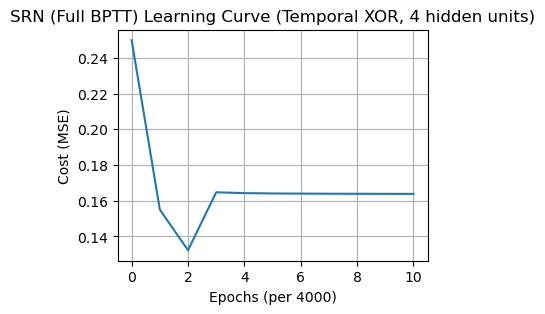


BPTT 最終予測 (最初の数ステップ):
X[0]=0, Y_true[0]=0, Y_pred[0]=0.0189 (Rounded: 0)
X[1]=0, Y_true[1]=0, Y_pred[1]=0.0012 (Rounded: 0)
X[2]=0, Y_true[2]=1, Y_pred[2]=0.9998 (Rounded: 1)
X[3]=1, Y_true[3]=0, Y_pred[3]=0.0311 (Rounded: 0)
X[4]=0, Y_true[4]=1, Y_pred[4]=0.9807 (Rounded: 1)
X[5]=1, Y_true[5]=1, Y_pred[5]=0.5174 (Rounded: 1)
X[6]=1, Y_true[6]=0, Y_pred[6]=0.5187 (Rounded: 1)
X[7]=0, Y_true[7]=1, Y_pred[7]=0.7496 (Rounded: 1)
X[8]=1, Y_true[8]=0, Y_pred[8]=0.5184 (Rounded: 1)
X[9]=0, Y_true[9]=1, Y_pred[9]=0.7502 (Rounded: 1)


In [73]:
X_txor_np, Y_txor_np = generate_temporal_xor_data(num_sequences=20)
# シーケンス長 T は X_txor_np.shape[0] (例: 20*3 - 1 = 59)

input_dim_txor = X_txor_np.shape[1]
hidden_dim_txor = 4 
output_dim_txor = Y_txor_np.shape[1]
params_txor_bptt = initialize_srn_parameters(input_dim_txor, hidden_dim_txor, output_dim_txor, random_seed=123)

num_epochs_bptt = 40000 # BPTTは収束に時間がかかることがある
learning_rate_bptt = 5 # 学習率調整が必要
print_every_bptt = num_epochs_bptt // 10
costs_bptt_np = []

print(f"\nSRN (Full BPTT) 学習開始 (Temporal XOR, {hidden_dim_txor} hidden units)...")
for epoch in range(num_epochs_bptt + 1):
    h0_txor = np.zeros((1, hidden_dim_txor))
    Y_hat_seq_txor, H_seq_txor, Caches_seq_txor = srn_forward_sequence(X_txor_np, h0_txor, params_txor_bptt)
    cost = mean_squared_error(Y_txor_np, Y_hat_seq_txor)
    
    grads_bptt = srn_bptt(Y_txor_np, Y_hat_seq_txor, H_seq_txor, Caches_seq_txor, params_txor_bptt)
    params_txor_bptt = update_srn_parameters(params_txor_bptt, grads_bptt, learning_rate_bptt)
    
    if epoch % print_every_bptt == 0:
        costs_bptt_np.append(cost)
        print(f"Epoch {epoch}, Cost (MSE): {cost:.6f}")

plt.figure(figsize=(4,3))
plt.plot(costs_bptt_np)
plt.xlabel(f"Epochs (per {print_every_bptt})")
plt.ylabel("Cost (MSE)")
plt.title(f"SRN (Full BPTT) Learning Curve (Temporal XOR, {hidden_dim_txor} hidden units)")
plt.grid(True); plt.show()

Y_final_pred_txor_bptt, _, _ = srn_forward_sequence(X_txor_np, np.zeros((1, hidden_dim_txor)), params_txor_bptt)
print("\nBPTT 最終予測 (最初の数ステップ):")
for t in range(min(10, len(X_txor_np))):
    print(f"X[{t}]={X_txor_np[t,0]:.0f}, Y_true[{t}]={Y_txor_np[t,0]:.0f}, Y_pred[{t}]={Y_final_pred_txor_bptt[t,0]:.4f} (Rounded: {np.round(Y_final_pred_txor_bptt[t,0]):.0f})")

## 4. PyTorchによるRNNの実装

PyTorchでは、`nn.RNN` モジュールを使うことで、SRNのような単純なRNNや、より複雑なRNN（LSTM, GRU）を簡単に構築し、学習させることができます。BPTTは自動微分機能 (`autograd`) によって自動的に処理されます。

### 4.1 PyTorch `nn.RNN` の使い方

*   **`nn.RNN` の初期化:**
    `rnn_layer = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')`
    *   `input_size`: 入力特徴量の次元数。
    *   `hidden_size`: 隠れ状態の次元数。
    *   `num_layers`: 積み重ねるRNN層の数（デフォルトは1）。
    *   `batch_first=True`: 入力と出力のテンソルの形状を `(batch_size, seq_length, feature_size)` とします。Falseの場合は `(seq_length, batch_size, feature_size)`。
    *   `nonlinearity`: 使用する活性化関数 (`'tanh'` または `'relu'`)。

*   **順伝播:**
    `outputs, h_n = rnn_layer(input_sequence, h_initial)`
    *   `input_sequence`: 形状 `(batch_size, seq_length, input_size)` の入力テンソル。
    *   `h_initial` (オプション): 形状 `(num_layers, batch_size, hidden_size)` の初期隠れ状態テンソル。指定しない場合はゼロベクトルで初期化されます。
    *   `outputs`: 形状 `(batch_size, seq_length, hidden_size)` の、各タイムステップにおける最後のRNN層の隠れ状態の出力。
    *   `h_n`: 形状 `(num_layers, batch_size, hidden_size)` の、シーケンス全体の最後のタイムステップにおける隠れ状態。

この `outputs` を後続の全結合層に渡して最終的な予測を得ます。

In [74]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first =True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid_out = nn.Sigmoid()
        
    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, hn = self.rnn(x, h0) # out: (batch_size, seq_len, hidden_size), hn: (num_layers, batch_size, hidden_size)

        # 全結合層を各タイムステップのRNN出力に適用
        # out.contiguous().view(-1, self.hidden_size) は (batch_size * seq_len, hidden_size) の形状に変換
        y_pred_logits = self.fc(out.contiguous().view(-1, self.hidden_size))
        y_pred = self.sigmoid_out(y_pred_logits)

        # y_predを元の形状に戻す
        y_pred = y_pred.view(x.size(0), x.size(1), -1)

        return y_pred, hn

In [75]:
# テスト
input_dim_pt = 1; hidden_dim_pt = 4; output_dim_pt = 1; num_rnn_layers_pt = 1
model_pt_rnn = SimpleRNN(input_dim_pt, hidden_dim_pt, output_dim_pt, num_rnn_layers_pt).to(device)
print("PyTorch SimpleRNN Model:\n", model_pt_rnn)

PyTorch SimpleRNN Model:
 SimpleRNN(
  (rnn): RNN(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid_out): Sigmoid()
)


### 4.2 Temporal XOR問題でのPyTorch RNN学習

PyTorchの自動微分機能により、BPTTを明示的に実装する必要はありません。


PyTorch RNN 学習開始 (Temporal XOR, 4 hidden units)...
Epoch 0, Loss (MSE): 0.264961
Epoch 10, Loss (MSE): 0.251385
Epoch 20, Loss (MSE): 0.248484
Epoch 30, Loss (MSE): 0.245379
Epoch 40, Loss (MSE): 0.242654
Epoch 50, Loss (MSE): 0.239031
Epoch 60, Loss (MSE): 0.233939
Epoch 70, Loss (MSE): 0.227536
Epoch 80, Loss (MSE): 0.219835
Epoch 90, Loss (MSE): 0.211350
Epoch 100, Loss (MSE): 0.203499
Epoch 110, Loss (MSE): 0.196048
Epoch 120, Loss (MSE): 0.184594
Epoch 130, Loss (MSE): 0.176914
Epoch 140, Loss (MSE): 0.172571
Epoch 150, Loss (MSE): 0.169711
Epoch 160, Loss (MSE): 0.182374
Epoch 170, Loss (MSE): 0.174772
Epoch 180, Loss (MSE): 0.171557
Epoch 190, Loss (MSE): 0.168976
Epoch 200, Loss (MSE): 0.167029
Epoch 210, Loss (MSE): 0.165133
Epoch 220, Loss (MSE): 0.163777
Epoch 230, Loss (MSE): 0.164849
Epoch 240, Loss (MSE): 0.169342
Epoch 250, Loss (MSE): 0.164903
Epoch 260, Loss (MSE): 0.161765
Epoch 270, Loss (MSE): 0.161373
Epoch 280, Loss (MSE): 0.159917
Epoch 290, Loss (MSE): 0.159062

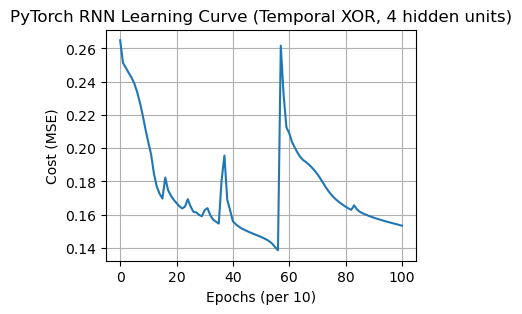


PyTorch RNN 最終予測 (最初の数ステップ):
X[0]=0, Y_true[0]=0, Y_pred[0]=0.0275 (Rounded: 0)
X[1]=0, Y_true[1]=0, Y_pred[1]=0.0867 (Rounded: 0)
X[2]=0, Y_true[2]=1, Y_pred[2]=0.8949 (Rounded: 1)
X[3]=1, Y_true[3]=0, Y_pred[3]=0.3470 (Rounded: 0)
X[4]=0, Y_true[4]=1, Y_pred[4]=0.8827 (Rounded: 1)
X[5]=1, Y_true[5]=1, Y_pred[5]=0.8677 (Rounded: 1)
X[6]=1, Y_true[6]=0, Y_pred[6]=0.3937 (Rounded: 0)
X[7]=0, Y_true[7]=1, Y_pred[7]=0.7793 (Rounded: 1)
X[8]=1, Y_true[8]=0, Y_pred[8]=0.2434 (Rounded: 0)
X[9]=0, Y_true[9]=1, Y_pred[9]=0.8336 (Rounded: 1)


In [83]:
X_txor_pt = torch.from_numpy(X_txor_np).float().unsqueeze(0).to(device) # (1, T, input_size)
Y_txor_pt = torch.from_numpy(Y_txor_np).float().unsqueeze(0).to(device) # (1, T, output_size)

model_txor_pt = SimpleRNN(input_dim_pt, hidden_dim_txor, output_dim_pt).to(device)
criterion_pt = nn.MSELoss() 
optimizer_pt = optim.Adam(model_txor_pt.parameters(), lr=0.01) # Adamの方が収束が速いことが多い
# optimizer_pt = optim.SGD(model_txor_pt.parameters(), lr=0.1)


num_epochs_pt_rnn = 1000
print_every_pt_rnn = num_epochs_pt_rnn // 100
costs_pt_rnn = []

print(f"\nPyTorch RNN 学習開始 (Temporal XOR, {hidden_dim_txor} hidden units)...")
for epoch in range(num_epochs_pt_rnn + 1):
    model_txor_pt.train()
    outputs_seq_pt, _ = model_txor_pt(X_txor_pt) # h0はデフォルトでNone (ゼロ初期化)
    loss = criterion_pt(outputs_seq_pt, Y_txor_pt)
    
    optimizer_pt.zero_grad()
    loss.backward() # ここでPyTorchがBPTTを実行
    optimizer_pt.step()
    
    if epoch % print_every_pt_rnn == 0:
        costs_pt_rnn.append(loss.item())
        print(f"Epoch {epoch}, Loss (MSE): {loss.item():.6f}")

plt.figure(figsize=(4,3))
plt.plot(costs_pt_rnn)
plt.xlabel(f"Epochs (per {print_every_pt_rnn})")
plt.ylabel("Cost (MSE)")
plt.title(f"PyTorch RNN Learning Curve (Temporal XOR, {hidden_dim_txor} hidden units)")
plt.grid(True); plt.show()

model_txor_pt.eval()
with torch.no_grad():
    Y_final_pred_pt_txor, _ = model_txor_pt(X_txor_pt)
    Y_final_pred_pt_txor = Y_final_pred_pt_txor.squeeze(0).cpu().numpy()

print("\nPyTorch RNN 最終予測 (最初の数ステップ):")
for t in range(min(10, X_txor_np.shape[0])):
    pred_val = Y_final_pred_pt_txor[t,0]
    print(f"X[{t}]={X_txor_np[t,0]:.0f}, Y_true[{t}]={Y_txor_np[t,0]:.0f}, Y_pred[{t}]={pred_val:.4f} (Rounded: {np.round(pred_val):.0f})")

## 5. 考察

*   **BPTTの概念とNumPyでの実装の意義:**
    *   NumPyでのBPTTの実装（特に逆伝播部分）は、RNNが時間軸に沿ってどのように情報を伝播し、誤差が過去に遡ってどのようにパラメータ更新に影響を与えるかの基本的なメカニズムを理解する上で非常に有益でした。
    *   特に、リカレント重み $W_{hh}$ の勾配が、シーケンス全体の各タイムステップからの寄与の合計となる点が、RNNにおける時間的依存性の学習の核心であることを示しています。
    *   一方で、その実装の複雑さ、特に時間ステップを逆向きにたどりながら勾配を蓄積していく処理は、間違いやすくデバッグも困難であることを体験しました。

*   **PyTorchによるRNN実装の利点:**
    *   **自動微分 (`autograd`):** BPTTの複雑な勾配計算を完全に抽象化し、`loss.backward()` の一言で実行してくれます。これにより、開発者は順伝播のロジック定義に集中でき、逆伝播の実装ミスを心配する必要がなくなります。
    *   **最適化されたRNNセル (`nn.RNN`, `nn.LSTM`, `nn.GRU`):** PyTorchが提供するこれらのモジュールは、内部で効率的に（しばしばCUDNNなどの低レベルライブラリを利用して）実装されており、手動のNumPyループよりもはるかに高速な計算が可能です。
    *   **柔軟性と拡張性:** `nn.Module` を組み合わせることで、より複雑なリカレントアーキテクチャや、他の層との組み合わせも容易に実現できます。
    *   **GPUサポート:** RNNの計算もGPUで大幅に高速化でき、より長いシーケンスや大きなモデルの学習が現実的になります。

*   **勾配消失・爆発問題について (再確認):**
    *   このノートブックで実装した単純なRNN（SRN）とBPTTは、特にシーケンスが長くなると、勾配が時間とともに指数関数的に小さくなる（勾配消失）か、大きくなる（勾配爆発）問題を起こしやすいです。
    *   **勾配消失**は、過去の遠い時点の情報が現在の学習にほとんど影響を与えなくなり、長期的な依存関係の学習を著しく困難にします。
    *   **勾配爆発**は、学習プロセスを不安定にし、発散させてしまう可能性があります。対策として**勾配クリッピング (gradient clipping)** がよく用いられます（PyTorchでは `torch.nn.utils.clip_grad_norm_` で実装可能）。
    *   LSTMやGRUといったゲート付きRNNは、これらの勾配の流れをより効果的に制御することで、勾配消失問題を緩和し、より長期の依存関係を学習できるように設計されました。

このノートブックでは、BPTTの基本的な考え方をNumPyでステップごとに確認し、PyTorchを使うことでRNNの学習がいかに簡潔かつ効率的に行えるかを体験しました。
この理解を基に、次の段階では、BPTTの課題を克服するために提案されたLSTMやGRUといった、より高度で実用的なリカレントニューラルネットワークの構造に進んでいくのが自然な流れです。